In [2]:
from collections import defaultdict
import os

import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from ml_downscaling_emulator.plotting import plot_map, create_map_fig, qq_plot
from ml_downscaling_emulator.training.dataset import build_input_transform, build_target_transform, SpatialStandardize

/home/henry/anaconda3/envs/cuda-downscaling/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
datasets = {
    "cpm": "bham_gcmx-4x_spechum-temp-vort_random",
    "gcm": "bham_60km-4x_spechum-temp-vort_random"
}

split = "train"

cpm_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", datasets["cpm"], f"{split}.nc")).drop_vars("pressure")
gcm_ds = xr.open_dataset(os.path.join(os.getenv("MOOSE_DERIVED_DATA"), "nc-datasets", datasets["gcm"], f"{split}.nc")).drop_vars("pressure")

cpm_ds

<xarray.Dataset>
Dimensions:                     (time: 509, grid_latitude: 64,
                                 grid_longitude: 64, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-01 12:00:00 ... 2080-09...
  * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
  * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
    season                      (time) int64 ...
Dimensions without coordinates: bnds
Data variables: (12/20)
    spechum250                  (time, grid_latitude, grid_longitude) float32 ...
    rotated_latitude_longitude  (time) float64 ...
    grid_latitude_bnds          (time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (time, grid_longitude, bnds) float32 ...
    time_bnds                   (time, bnds) object ...
    spechum500                  (time, grid_latitude, grid_longitude) float32 ...
    ...                          ...
    temp925                     (time, grid_latitude, grid_longitude) float32 ...
    vorticity250                (time, grid_latitude, grid_longitude) float64 ...
    vorticity500                (time, grid_latitude, grid_longitude) float64 ...
    vorticity700                (time, grid_latitude, grid_longitude) float64 ...
    vorticity850                (time, grid_latitude, grid_longitude) float64 ...
    vorticity925                (time, grid_latitude, grid_longitude) float64 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.7
    source:       Data from Met Office Unified Model
    um_version:   10.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [7]:
VARIABLE = "temp850"

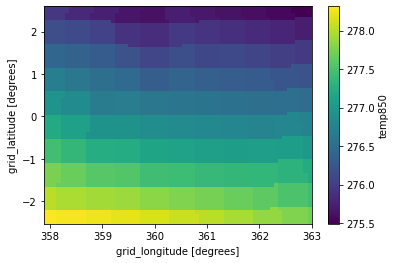

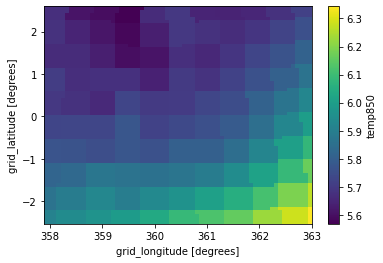

In [4]:
cpm_ds[VARIABLE].mean(dim=["time"]).plot()
plt.show()
cpm_ds[VARIABLE].std(dim=["time"]).plot()
plt.show()

In [5]:
ispt_xfm = build_input_transform([VARIABLE], 64, key="spatial")
cpm_ds = ispt_xfm.fit_transform(cpm_ds)

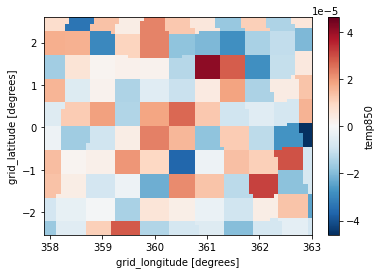

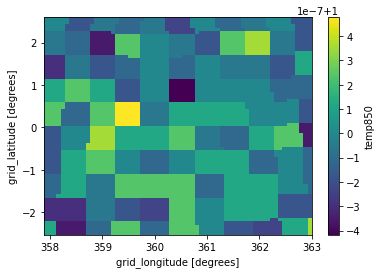

In [6]:
cpm_ds[VARIABLE].mean(dim=["time"]).plot()
plt.show()
cpm_ds[VARIABLE].std(dim=["time"]).plot()
plt.show()

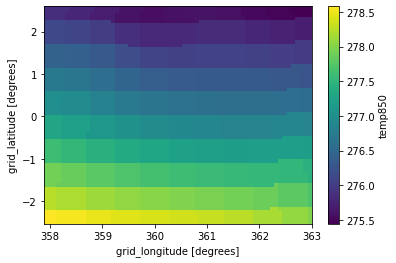

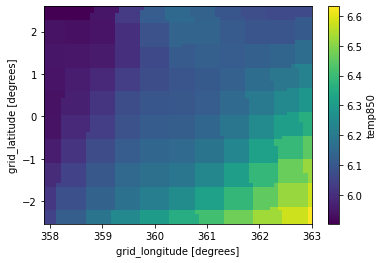

In [7]:
gcm_ds[VARIABLE].mean(dim=["time"]).plot()
plt.show()
gcm_ds[VARIABLE].std(dim=["time"]).plot()
plt.show()

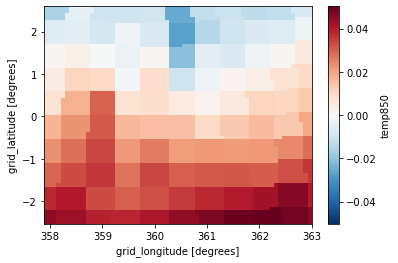

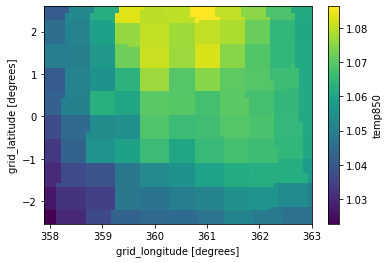

In [8]:
gcm_ds = ispt_xfm.transform(gcm_ds)
gcm_ds[VARIABLE].mean(dim=["time"]).plot()
plt.show()
gcm_ds[VARIABLE].std(dim=["time"]).plot()
plt.show()

## GCM --> CPM

In [18]:
# make eval source distribution is like training source distribution
xr_data_train = (((gcm_ds - gcm_ds.mean(dim=["time"]))/gcm_ds.std(dim=["time"]))*cpm_ds.std(dim=["time"])) + cpm_ds.mean(dim=["time"])

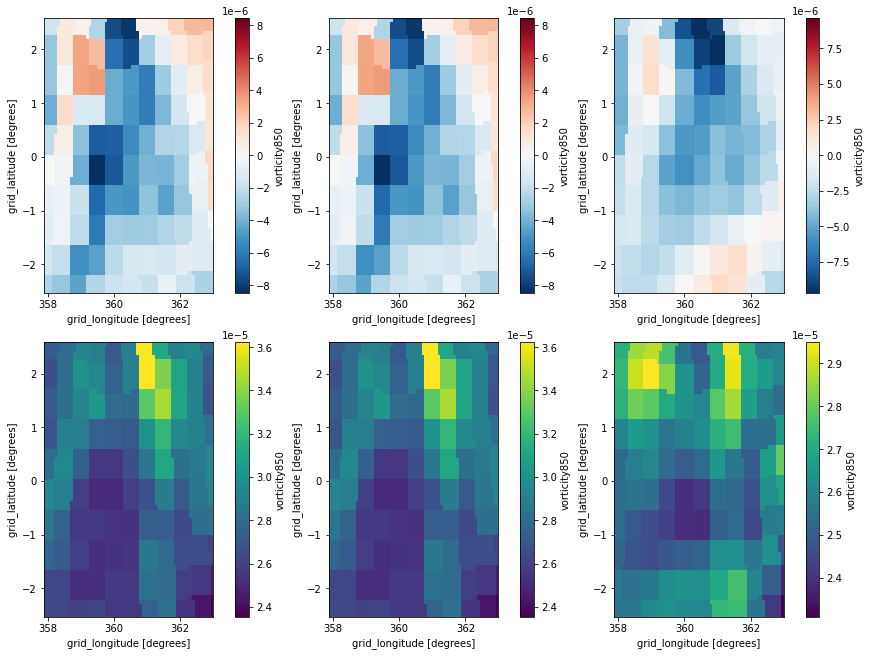

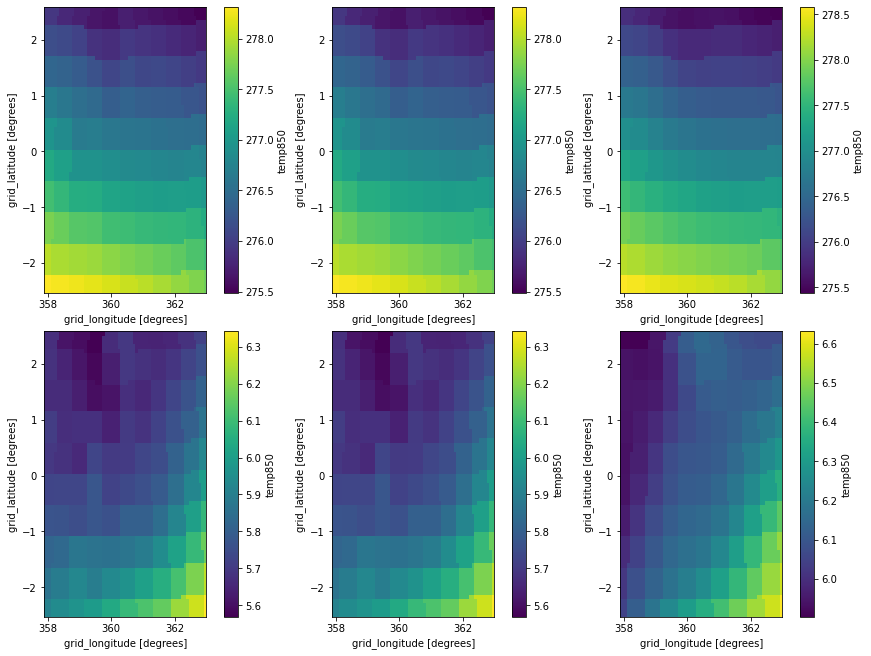

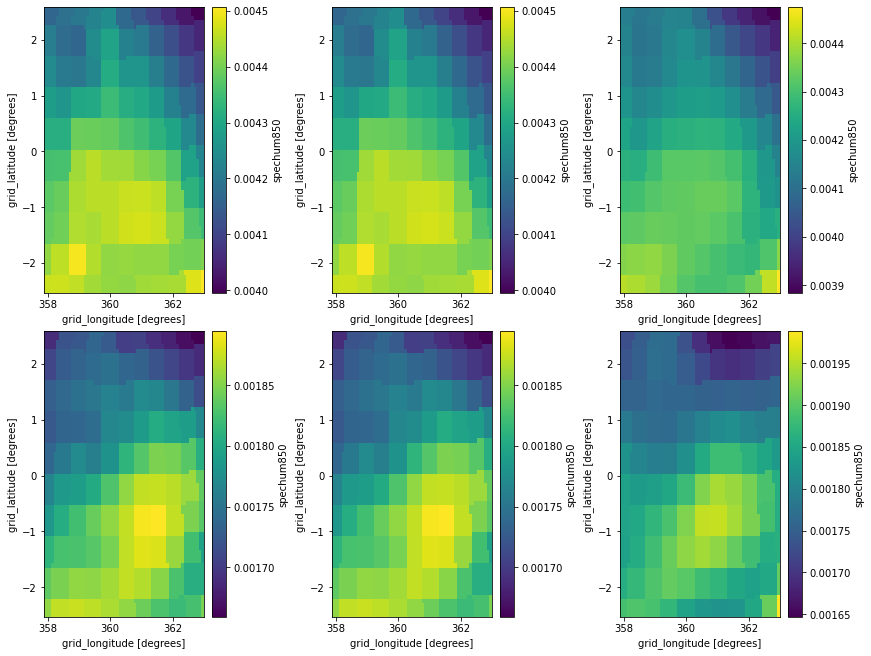

In [19]:
for variable in ["vorticity850", "temp850", "spechum850"]:

    _, axd = plt.subplot_mosaic([["mean cpm", "mean gcm->cpm", "mean gcm"], ["std cpm", "std gcm->cpm", "std gcm", ]], constrained_layout=True, figsize=(12, 9))

    cpm_ds[variable].mean(dim=["time"]).plot(ax=axd["mean cpm"])

    gcm_ds[variable].mean(dim=["time"]).plot(ax=axd["mean gcm"])

    xr_data_train[variable].mean(dim=["time"]).plot(ax=axd["mean gcm->cpm"])

    cpm_ds[variable].std(dim=["time"]).plot(ax=axd["std cpm"])

    gcm_ds[variable].std(dim=["time"]).plot(ax=axd["std gcm"])

    xr_data_train[variable].std(dim=["time"]).plot(ax=axd["std gcm->cpm"])
